# Supervised Challenge

Now you should have a solid understanding of the basic concepts of supervised learning. In this challenge, you will be working with a dataset that is a bit more complex than the ones you have seen so far. This is a real dataset from the CBS website. Your assignment consists of two parts, a classification task as well as a regression task. You can use any of the models and techniques you have learned so far. 

We will first import the relevant data and then describe the individual challenges.

In [ ]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.environ['DATA_DIRECTORY'] = '/content'
else:
    os.environ['DATA_DIRECTORY'] = '../../data'

data_directory = os.getenv('DATA_DIRECTORY')

In [ ]:
%%bash
if [ ! -f "$DATA_DIRECTORY/course-data.zip" ]; then
    wget "https://gitlab.com/api/v4/projects/52375047/jobs/artifacts/master/raw/data/course-data.zip?job=build_data_zip" -O "$DATA_DIRECTORY/course-data.zip"
    unzip "$DATA_DIRECTORY/course-data.zip" -d "$DATA_DIRECTORY"
fi

## Read reference data: description of columns in data

The CBS dataset comes with an extra file describing the columns in the dataset. Let's read this file first.

In [ ]:
import pandas as pd
 
kwb_description = pd.read_csv(os.path.join(data_directory, "kwb-2018-toelichting.csv"), delimiter=';', names=["column_name", "description", "comments"], index_col=0)
kwb_description.drop(columns=["comments"], inplace=True)
kwb_description.head()

description
column_name                 
gwb_code_10      gwb code 10
gwb_code_8        gwb code 8
regio        Regioaanduiding
gm_naam         Gemeentenaam
recs             Soort regio

We can see that for every column in the dataset, there is a description of the column. This will help us understand the dataset better. So if for example we want to know what the column `a_pau` means, we can look it up in this file using the following code:

In [3]:
kwb_description.loc['a_pau']  # use these descriptions to try and determine the parameter being asked.

description    Personenauto's totaal
Name: a_pau, dtype: object

After reading the metadata, we can read the dataset itself. The dataset is stored in a CSV file, so we can use the `read_csv` function from the `pandas` library to read the dataset. We will also print the first few rows of the dataset to get an idea of what the dataset looks like.

In [ ]:
kwb_data = pd.read_csv(os.path.join(data_directory, "kwb-2018-full.csv"), delimiter=';', encoding='latin1')
kwb_data.head()

gwb_code_10  gwb_code_8               regio     gm_naam      recs  \
0        NL00           0           Nederland   Nederland      Land   
1      GM0003           3          Appingedam  Appingedam  Gemeente   
2    WK000300         300             Wijk 00  Appingedam      Wijk   
3  BU00030000       30000  Appingedam-Centrum  Appingedam     Buurt   
4  BU00030001       30001     Appingedam-West  Appingedam     Buurt   

     gwb_code ind_wbi     a_inw    a_man  a_vrouw  ...  g_afs_kv  g_afs_sc  \
0        NL00       .  17181084  8527041  8654043  ...         .         .   
1      GM0003       .     11801     5751     6050  ...         .         .   
2    WK000300       1     11800     5750     6050  ...         .         .   
3  BU00030000       1      2355     1120     1235  ...         .         .   
4  BU00030001       1      3030     1505     1525  ...         .         .   

   g_3km_sc  a_opp_ha  a_lan_ha  a_wat_ha  pst_mvp  pst_dekp  ste_mvs  ste_oad  
0         .   4154338   3367109    787228        .         .        2     1978  
1         .      2458      2378        80        .         .        3     1051  
2         .      2458      2378        80        .         .        3     1051  
3         .        90        84         5     9901         1        3     1195  
4         .       163       158         5     9903         5        4      896  

[5 rows x 109 columns]

## Selecting the data we want to use

The dataset contains several types of regions, but we are only interested in the municipalities. We first have to find the rows that correspond to municipalities. Let's look at the metadata to find the column containing the region type.

In [5]:
kwb_description

description
column_name                            
gwb_code_10                 gwb code 10
gwb_code_8                   gwb code 8
regio                   Regioaanduiding
gm_naam                    Gemeentenaam
recs                        Soort regio
...                                 ...
a_wat_ha              Oppervlakte water
pst_mvp      Meest voorkomende postcode
pst_dekp             Dekkingspercentage
ste_mvs          Mate van stedelijkheid
ste_oad      Omgevingsadressendichtheid

[109 rows x 1 columns]

We can see here that the `recs` column contains the region type:

In [6]:
kwb_description.loc['recs']

description    Soort regio
Name: recs, dtype: object

To see what values the `recs` column can have, we can use the `unique` function from the `pandas` library. This function returns all unique values in a column.

In [7]:
kwb_data['recs'].unique()

array(['Land', 'Gemeente', 'Wijk', 'Buurt'], dtype=object)

In [8]:
selected_region_type = 'Gemeente'

We can filter the dataset to only include the municipalities by selecting the rows where the `recs` column is equal to `Gemeente`. 

In [9]:
data_for_selected_region_type = kwb_data[kwb_data.recs == selected_region_type]
data_for_selected_region_type.head()

gwb_code_10  gwb_code_8       regio     gm_naam      recs gwb_code ind_wbi  \
1       GM0003           3  Appingedam  Appingedam  Gemeente   GM0003       .   
9       GM0005           5       Bedum       Bedum  Gemeente   GM0005       .   
19      GM0009           9    Ten Boer    Ten Boer  Gemeente   GM0009       .   
34      GM0010          10    Delfzijl    Delfzijl  Gemeente   GM0010       .   
64      GM0014          14   Groningen   Groningen  Gemeente   GM0014       .   

     a_inw   a_man  a_vrouw  ...  g_afs_kv  g_afs_sc  g_3km_sc  a_opp_ha  \
1    11801    5751     6050  ...         .         .         .      2458   
9    10475    5235     5240  ...         .         .         .      4496   
19    7292    3616     3676  ...         .         .         .      4573   
34   24864   12475    12389  ...         .         .         .     22750   
64  202810  101299   101511  ...         .         .         .     10150   

    a_lan_ha  a_wat_ha  pst_mvp  pst_dekp  ste_mvs  ste_oad  
1       2378        80        .         .        3     1051  
9       4454        41        .         .        4      685  
19      4531        42        .         .        5      372  
34     13307      9443        .         .        4      677  
64      9492       658        .         .        1     3456  

[5 rows x 109 columns]

Finally, we can also check how many municipalities are in the dataset.

In [10]:
len(data_for_selected_region_type)

380

The filtered dataset contains 380 municipalities. The data is from 2018, and indeed that number is correct. 

-----------------

# Classification challenge

Learn a model that predicts `ste_mvs`, the degree of urbanisation.


In [1]:
#begin solution


## Get the Labels

Next, it is time to get our features and target variable. The target variable is the degree of urbanization, which is stored in the `ste_mvs` column. The features can be the other columns in the dataset. We can retrieve the target variable by using the following code:

In [11]:
y_true = data_for_selected_region_type[['ste_mvs']]

Now the variable `y_true` contains the target variable. In this case, the target variable is the degree of urbanization. CBS classifies the degree of urbanization into five classes. Based on the environmental address density, each neighborhood, district, or municipality has been assigned an urbanization class. The following classification has been used:

Value | Description | Address density
--- | --- | ---
1 | very strongly urbanized | >= 2,500 addresses per km²
2 | strongly urbanized | 1,500 - 2,500 addresses per km²
3 | moderately urbanized | 1,000 - 1,500 addresses per km²
4 | weakly urbanized | 500 - 1,000 addresses per km²
5 | non-urbanized | < 500 addresses per km²

Let's see how many municipalities are in each class.

In [12]:
target_name = ['ste_mvs']
target_categories = ['very strongly urbanized', 'strongly urbanized', 'moderately urbanized', 'weakly urbanized', 'non-urbanized']
y_true[target_name].value_counts().sort_index()

ste_mvs
1           19
2           74
3           78
4          135
5           74
Name: count, dtype: int64



## Selecting some features

The dataset contains a lot of characteristics per municipality. Not all of these characteristics are useful for predicting the degree of urbanization. We can select a subset of the features that we think are most relevant. For example, we can select the area of the municipality in hectares and the number of households as features:

In [13]:
feature_names = ['a_hh', 'a_opp_ha'] 
X = data_for_selected_region_type[feature_names]
X.head(5)

a_hh  a_opp_ha
1     5540      2458
9     4391      4496
19    2980      4573
34   11617     22750
64  122541     10150

## Split the Data into training and testing data

Now that we have our features and target variable, we can split the data into training and testing data. We will use 80% of the data for training and 20% for testing. We can use the `train_test_split` function from the `sklearn` library to split the data.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_true, random_state=42)

## Train the Model

Once we have split the data we can train a RandomForest model. We can use the `RandomForestClassifier` class from the `sklearn` library to create a RandomForest model. We can then use the `fit` method to train the model on the training data.

In [15]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_base_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_base_model.fit(X_train, y_train)

y_pred = rf_base_model.predict(X_test)

print(f"Your model scores: {classification_report(y_test, y_pred)}")

Your model scores:               precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.71      0.71      0.71        21
           3       0.59      0.59      0.59        22
           4       0.63      0.73      0.68        30
           5       0.80      0.63      0.71        19

    accuracy                           0.66        95
   macro avg       0.65      0.60      0.62        95
weighted avg       0.67      0.66      0.66        95



/Users/timdejong/.pyenv/versions/ai_course/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Design features that allows you to classify the degree of urbanisation as best as you can!

Try using different features, compute new features or use different classification algorithm.

In [16]:
# a_opp_ha is totale oppervlakte in hele hectaren.
# een km2 is 100 hectaren
# data: inwoners, huishoudens
# 1: zeer sterk stedelijk >= 2 500 adressen per km²
# 2: sterk stedelijk 1 500 - 2 500 adressen per km²
# 3: matig stedelijk 1 000 - 1 500 adressen per km²
# 4: weinig stedelijk 500 - 1 000 adressen per km²
# 5: niet stedelijk < 500 adressen per km²

data_for_selected_region_type['a_hh_p_km2'] = data_for_selected_region_type['a_hh'] / (data_for_selected_region_type['a_opp_ha']/100)
data_for_selected_region_type[['a_hh_p_km2','a_hh','a_opp_ha']].head(5)

/var/folders/5s/1qqrrxd175v_vzyy65mh_y0m0000gn/T/ipykernel_4272/3336679801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_selected_region_type['a_hh_p_km2'] = data_for_selected_region_type['a_hh'] / (data_for_selected_region_type['a_opp_ha']/100)


a_hh_p_km2    a_hh  a_opp_ha
1    225.386493    5540      2458
9     97.664591    4391      4496
19    65.165099    2980      4573
34    51.063736   11617     22750
64  1207.300493  122541     10150

In [17]:
X = data_for_selected_region_type[['a_hh_p_km2','a_hh','a_opp_ha']]
X_train, X_test, y_train, y_test = train_test_split(X, y_true, random_state=42)

In [18]:
# all in one cell
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(f"Your model scores: {classification_report(y_test, y_pred)}")


/Users/timdejong/.pyenv/versions/ai_course/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Your model scores:               precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.74      0.81      0.77        21
           3       0.61      0.64      0.62        22
           4       0.64      0.60      0.62        30
           5       0.65      0.68      0.67        19

    accuracy                           0.66        95
   macro avg       0.73      0.61      0.64        95
weighted avg       0.67      0.66      0.66        95



In [2]:
#end solution

-----------------

# Regression challenge

Learn a model that predicts `a_pau`, the number of cars. Beware, this is a real number now, not a class. This is a regression problem!


The city of The Hague and Heerlen expects that the number of inhabitants will increase with 10% in the next 5 years.
What will be the impact on the number of cars in the city? This is important information when planning public infrastructure.



In [19]:
kwb_description.loc['a_pau']  

description    Personenauto's totaal
Name: a_pau, dtype: object

In [3]:
#begin solution

## Get the Labels

First, we get the target variable. The target variable is the number of cars, which is stored in the `a_pau` column. We can retrieve the target variable by using the following code:

In [20]:
y_reg_true = kwb_data[['a_pau']]

## Selecting some features

In [21]:
# should we use kwb full instead??

kwb_data.columns

Index(['gwb_code_10', 'gwb_code_8', 'regio', 'gm_naam', 'recs', 'gwb_code',
       'ind_wbi', 'a_inw', 'a_man', 'a_vrouw',
       ...
       'g_afs_kv', 'g_afs_sc', 'g_3km_sc', 'a_opp_ha', 'a_lan_ha', 'a_wat_ha',
       'pst_mvp', 'pst_dekp', 'ste_mvs', 'ste_oad'],
      dtype='object', length=109)

In [62]:
import numpy as np

kwb_data = kwb_data.replace(".", np.nan)

<Axes: >

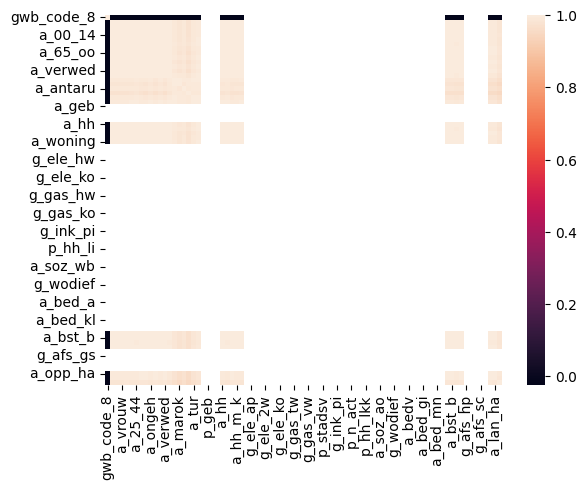

In [66]:
import seaborn as sns

pearson_corr = kwb_data.corr(method='pearson', numeric_only=True)
sns.heatmap(pearson_corr)

<Axes: >

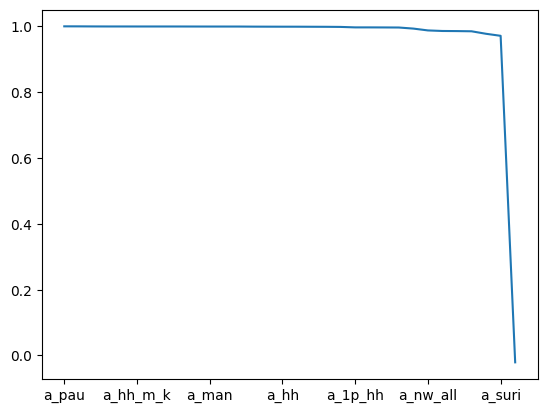

In [80]:
pearson_corr['a_pau'].sort_values(ascending=False).plot()

In [74]:
selected_columns = pearson_corr['a_pau'].sort_values(ascending=False).index[:30]

In [75]:
X_reg = kwb_data[selected_columns] #['a_hh','a_opp_ha', 'g_woz']]
X_reg

a_pau  a_bst_b  a_gehuwd  a_45_64   a_m2w  a_hh_m_k  a_65_oo  \
0      8373245  6649495   6710175  4839917  661640   2594888  3239116   
1         5440     4650      4924     3562     550      1700     2825   
2         5435     4645      4925     3560     550      1700     2825   
3         1075      925       850      715      95       240      685   
4         1545     1305      1405     1020     155       470      605   
...        ...      ...       ...      ...     ...       ...      ...   
16767       25       20        75       65       0        40       15   
16768      290      240       225      155      30        80      100   
16769      570      450       350      235      50       145       95   
16770      480      365       415      305      65       130      165   
16771      400      340       370      225      60       125      155   

       a_hh_z_k  a_verwed  a_00_14  ...  a_1p_hh  a_lan_ha  a_w_all  a_opp_ha  \
0       2265409    858676  2762624  ...  2997617   3367109  1729016   4154338   
1          1775       829     1773  ...     2065      2378      869      2458   
2          1775       830     1770  ...     2065      2378      870      2458   
3           370       255      230  ...      690        84      140        90   
4           495       120      495  ...      350       158      160       163   
...         ...       ...      ...  ...      ...       ...      ...       ...   
16767        10         5       40  ...       10        81        0        81   
16768        60        35       85  ...       35       693       15       695   
16769       105        20      150  ...      100       403       45       413   
16770       125        40       80  ...       55       848       40       866   
16771       105        25      125  ...       30       787       25       790   

       a_ov_nw  a_nw_all   a_tur  a_antaru  a_wat_ha  a_marok  
0       933870   2242843  404459    156294    787228   396539  
1          326       814     257       100        80       48  
2          325       815     255       100        80       45  
3           55        90      10        15         5        0  
4           45       110      35        20         5        5  
...        ...       ...     ...       ...       ...      ...  
16767        0         0       0         0         0        0  
16768        5         5       0         0         3        0  
16769       10        15       5         0         9        0  
16770        0         0       0         0        18        0  
16771        5         5       0         0         2        0  

[16772 rows x 30 columns]

In [76]:
import numpy as np

X_reg.replace(".", np.nan, inplace=True)

/var/folders/5s/1qqrrxd175v_vzyy65mh_y0m0000gn/T/ipykernel_4272/2603550806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reg.replace(".", np.nan, inplace=True)


In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X_reg = SimpleImputer(strategy='mean').fit_transform(X_reg)
X_reg = StandardScaler().fit_transform(X_reg) 

## Split the Data into training and testing data

After selecting the features and the label, we can split the data into training and testing data. We will use 80% of the data for training and 20% for testing. We can use the `train_test_split` function from the `sklearn` library to split the data.

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg_true, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12579, 30), (4193, 30), (12579, 1), (4193, 1))

## Train a Baseline Model

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf_reg_model = RandomForestRegressor(n_estimators=300, random_state=42)

rf_reg_model.fit(X_train, y_train.values.ravel())

y_reg_pred = rf_reg_model.predict(X_test)
print(root_mean_squared_error(y_test, y_reg_pred))

126133.94261047641


In [4]:
#end solution